In [1]:
"""
Tutorial to demonstrate running parameter estimation on a reduced parameter
space for an injected signal.

This example estimates the masses using a uniform prior in both component masses
and distance using a uniform in comoving volume prior on luminosity distance
between luminosity distances of 100Mpc and 5Gpc, the cosmology is Planck15.
"""

import bilby
import numpy as np

import matplotlib.pyplot as plt
import config
config.conf_matplolib()

# NR data

In [2]:
Msun = 2*1e30
G = 6.6743 * 1e-11
c = 2.99792458 * 1e8
Mevent = 62

Tc = G*Msun*Mevent/(c**3)

merger_time = 0#1126259642.413

In [3]:
nr_data = np.genfromtxt("prepared_waveform_fseries2.txt")

In [4]:
nr_data.shape

(2023, 3)

In [5]:
# Simulation name
sim_name = 'SXS:BBH:0001'

# Parameters
M = 40
D = 100
inc = 0
coa_phase = 0
sampling_frequency=2048
delta_t = 1./sampling_frequency
q=1

In [6]:
nr_data

array([[ 0.00000000e+00,  1.89241081e-24,  5.82035397e-24],
       [ 5.06429278e-01, -2.38704400e-25,  6.58338046e-24],
       [ 1.01285856e+00,  5.18911984e-26,  6.52149086e-24],
       ...,
       [ 1.02298714e+03,  4.80704653e-28,  3.88054965e-27],
       [ 1.02349357e+03,  5.27458788e-28,  3.90351774e-27],
       [ 1.02400000e+03,  5.43443108e-28,  3.91128205e-27]])

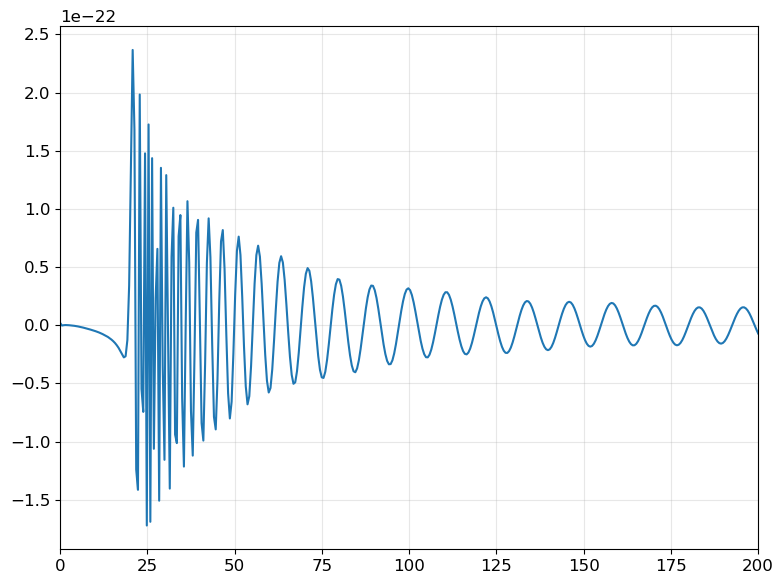

In [41]:
hp0 = nr_data[:, 1]
hc0 = nr_data[:, 2]

maxloc = np.argmax(hp0**2 + hc0**2)

hf0 = nr_data[:, 0]
#ht0 -= ht0[maxloc]
#ht0 += merger_time

plt.plot(hf0, hp0)
plt.xlim(0 ,200)
plt.show()

In [8]:
fdomain_pol_dict = {"plus": hp0, "cross": hc0}

In [9]:
def nr_injection(freq_axis):
    """
    This function produces the amplitude for a given 
    NR-derived signal at any given time for a given data file.
    
    Parameters
    ----------
    time : array-like
        A time, or an array of times, at which the amplitudes should be returned.
    datafile : str
        The path to the data file containing the injection.
    """

    local_freq_axis = hf0

    hp = np.interp(freq_axis, local_freq_axis, hp0).real
    hx = np.interp(freq_axis, local_freq_axis, hc0).real
    
    #print(hp, hx)
    return {"plus": hp, "cross": hx}

In [44]:

# Specify the output directory and the name of the simulation.
outdir = "outdir"
label = f"fast_tutorial_nr_{sim_name}_inj_f_two_sonic_2"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
#bilby.core.utils.random.seed(88170235)

In [45]:
Mtotal=40
mass1 = Mtotal*q/(1+q)
mass2 = Mtotal/(1+q)
#merger_time = 1126259642.413


# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
analysis_duration = 1.97412109375 #4#Mtotal*len(ht0)/sampling_frequency
#sampling_frequency = 2048.0
minimum_frequency = 20

print("Analysis duration is ", analysis_duration)

# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
injection_parameters = dict(
    mass_1=mass1,
    mass_2=mass2,
    a_1=0.0,
    a_2=0.0,
    tilt_1=0.0,
    tilt_2=0.0,
    phi_12=0,
    phi_jl=0,
#    spin_1x=0,
#    spin_1y=0,
#    spin_1z=0,
#    spin_2x=0,
#    spin_2y=0,
#    spin_2z=0,
    luminosity_distance=D,
    geocent_time=merger_time,
    theta_jn=inc,
    psi=0,
    phase=coa_phase,
    ra=1.375,
    dec=-1.2108,
)



Analysis duration is  1.97412109375


In [46]:

# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=20.0,
    minimum_frequency=minimum_frequency,
)



In [47]:

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=analysis_duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
    )

00:04 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [48]:
# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1"])

ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=analysis_duration,
    start_time= merger_time - analysis_duration,
)

#new_time = np.linspace(ht0[0], ht0[-1], 4097)

inj_pol_dict = fdomain_pol_dict#nr_injection(new_time)

print(inj_pol_dict['plus'].shape)

# Create a different waveform generator for injection
ifos.inject_signal(
    injection_polarizations=inj_pol_dict, 
    parameters=injection_parameters
)


00:04 bilby INFO    : Injected signal in H1:
00:04 bilby INFO    :   optimal SNR = 104.58
00:04 bilby INFO    :   matched filter SNR = 105.29+0.84j
00:04 bilby INFO    :   mass_1 = 20.0
00:04 bilby INFO    :   mass_2 = 20.0
00:04 bilby INFO    :   a_1 = 0.0
00:04 bilby INFO    :   a_2 = 0.0
00:04 bilby INFO    :   tilt_1 = 0.0
00:04 bilby INFO    :   tilt_2 = 0.0
00:04 bilby INFO    :   phi_12 = 0
00:04 bilby INFO    :   phi_jl = 0
00:04 bilby INFO    :   luminosity_distance = 100
00:04 bilby INFO    :   geocent_time = 0
00:04 bilby INFO    :   theta_jn = 0
00:04 bilby INFO    :   psi = 0
00:04 bilby INFO    :   phase = 0
00:04 bilby INFO    :   ra = 1.375
00:04 bilby INFO    :   dec = -1.2108


(2023,)


[{'plus': array([ 1.89241081e-24, -2.38704400e-25,  5.18911984e-26, ...,
          4.80704653e-28,  5.27458788e-28,  5.43443108e-28]),
  'cross': array([5.82035397e-24, 6.58338046e-24, 6.52149086e-24, ...,
         3.88054965e-27, 3.90351774e-27, 3.91128205e-27])}]

In [49]:
ifos.plot_data()

In [50]:
print(inj_pol_dict['plus'].shape)

(2023,)


In [51]:

# Set up a PriorDict, which inherits from dict.
# By default we will sample all terms in the signal models.  However, this will
# take a long time for the calculation, so for this example we will set almost
# all of the priors to be equall to their injected values.  This implies the
# prior is a delta function at the true, injected value.  In reality, the
# sampler implementation is smart enough to not sample any parameter that has
# a delta-function prior.
# The above list does *not* include mass_1, mass_2, theta_jn and luminosity
# distance, which means those are the parameters that will be included in the
# sampler.  If we do nothing, then the default priors get used.
priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "luminosity_distance",
    "theta_jn",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
]:
    priors[key] = injection_parameters[key]

# Perform a check that the prior does not extend to a parameter space longer than the data
priors.validate_prior(analysis_duration, minimum_frequency)

# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator
)


00:04 bilby INFO    : No prior given, using default BBH priors in /mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [52]:
injection_parameters['geocent_time']

0

In [53]:

# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    npoints=150,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
)

00:04 bilby INFO    : Running for label 'fast_tutorial_nr_SXS:BBH:0001_inj_f_two_sonic_2', output will be saved to 'outdir'
00:04 bilby INFO    : Using lal version 7.5.0
00:04 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.5.0;Id: edd3f4e61431c1a0c6a7be13c0be9644be1f6745;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
00:04 bilby INFO    : Using lalsimulation version 5.4.0
00:04 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v5.4.0;Id: 57c31779c344c6abf3c1d294bab00dd58ed17875;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
00:04 bilby INFO    : Analysis priors:
00:04 bilby INFO    : mass_ratio=bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
00:04 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=100, name='chirp_mass', latex_label='

1it [00:00, ?it/s]

00:10 bilby INFO    : Written checkpoint file outdir/fast_tutorial_nr_SXS:BBH:0001_inj_f_two_sonic_2_resume.pickle
/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
00:10 bilby INFO    : Rejection sampling nested samples to obtain 477 posterior samples
00:10 bilby INFO    : Sampling time: 0:05:22.352017
00:10 bilby INFO    : Summary of results:
nsamples: 477
ln_noise_evidence: -7488.005
ln_evidence: -20699.506 +/-  0.362
ln_bayes_factor: -13211.501 +/-  0.362



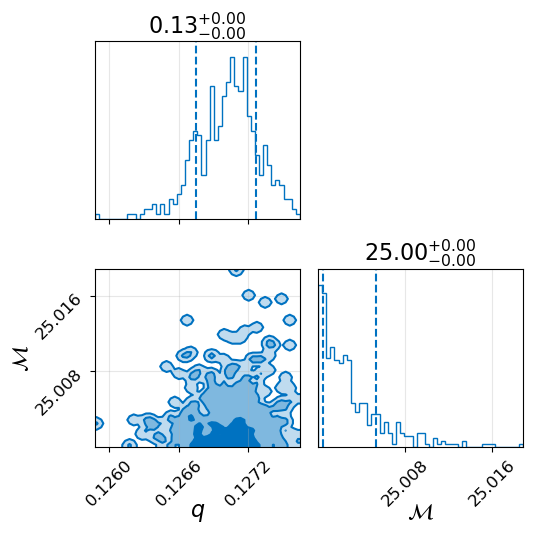

In [54]:
# Make a corner plot.
result.plot_corner()

In [31]:
mass1

20.0

In [35]:
def ChirpMassFromIndividualMasses(mass_1, mass_2):

    return ((mass_1 * mass_2)**(3/5))/(mass_1 + mass_2)**(1/5)

In [36]:
Mchirp_act = ChirpMassFromIndividualMasses(mass1, mass2)

In [37]:
Mchirp_act

17.411011265922482

In [42]:
bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(25, 0.13)

(87.13440821737065, 11.327473068258184)